In [1]:
import urllib.request
import gzip
import shutil
import pandas as pd
import requests
import zipfile
import tempfile
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_orig()

In [2]:
AirbnbURL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2021-11-02/data/listings.csv.gz"
urllib.request.urlretrieve(AirbnbURL, "listing.csv.gz")
with gzip.open('listing.csv.gz', 'rb') as f_in:
    with open('listing.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
airbnb = pd.read_csv('listing.csv',low_memory=False)

In [4]:
airbnb = airbnb.drop(['listing_url', 'scrape_id', 'last_scraped','neighborhood_overview', 'picture_url', 'host_url',
       'host_name', 'host_since',
       'host_response_time', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'bathrooms', 'beds', 'amenities',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'], axis=1)

In [5]:
def get_data():
    url = "https://geodacenter.github.io/data-and-lab/data/nycnhood_acs.zip"
    response = requests.get(url)
    return url, response.content


if __name__ == '__main__':
    url, data = get_data()  

    _tmp_file = tempfile.TemporaryFile()  
    print(_tmp_file)

    _tmp_file.write(data) 
    

    zf = zipfile.ZipFile(_tmp_file, mode='r')
    for names in zf.namelist():
        f = zf.extract(names, './zip')  
        print(f)

    zf.close()

<_io.BufferedRandom name=62>
zip/NYC_Nhood ACS2008_12.dbf
zip/__MACOSX
zip/__MACOSX/._NYC_Nhood ACS2008_12.dbf
zip/NYC_Nhood ACS2008_12.prj
zip/__MACOSX/._NYC_Nhood ACS2008_12.prj
zip/NYC_Nhood ACS2008_12.shp
zip/__MACOSX/._NYC_Nhood ACS2008_12.shp
zip/NYC_Nhood ACS2008_12.shx
zip/__MACOSX/._NYC_Nhood ACS2008_12.shx


In [6]:
NTA = gpd.read_file("zip/NYC_Nhood ACS2008_12.shp")
NTA.head(4)

,UEMPRATE,cartodb_id,borocode,withssi,withsocial,withpubass,struggling,profession,popunemplo,poptot,...,boroname,popdty,ntacode,medianinco,medianagem,medianagef,medianage,HHsize,gini,geometry
0,0.095785,1,3,652,5067,277,6421,889,2225,48351,...,Brooklyn,497498.701,BK45,1520979,663.3,777.1,722.6,2.96421052631579,0.386315789473684,"POLYGON ((-73.91716 40.63173, -73.91722 40.631..."
1,0.090011,2,3,2089,7132,1016,10981,1075,2652,61584,...,Brooklyn,589296.926,BK17,1054259,791.4,868.5,827.6,2.46578947368421,0.448089473684211,"POLYGON ((-73.91809 40.58657, -73.91813 40.586..."
2,0.130393,3,3,3231,8847,2891,21235,712,6483,100130,...,Brooklyn,1506628.84,BK61,980637,863.1,983.9,923.8,2.42925925925926,0.473666666666667,"POLYGON ((-73.92165 40.67887, -73.92171 40.678..."
3,0.086633,4,3,1103,3508,553,7188,475,1709,33155,...,Brooklyn,468975.876,BK90,519058,333.6,350.1,341.3,2.189,0.44139,"POLYGON ((-73.92406 40.71411, -73.92404 40.714..."


In [7]:
cols = ['medianagef', 'medianage', 'HHsize','gini']
NTA[cols] = NTA[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [8]:
NTA = NTA.to_crs("EPSG:32118")

In [9]:
geometry = [Point(xy) for xy in zip(airbnb.longitude, airbnb.latitude)]
Airbnb_sf = GeoDataFrame(airbnb, crs="EPSG:4326", geometry=geometry)

In [10]:
Airbnb_sf=Airbnb_sf.to_crs("EPSG:32118")

In [11]:
Airbnb_NTA=gpd.sjoin(NTA,Airbnb_sf)
Airbnb_NTA.head(4)

,UEMPRATE,cartodb_id,borocode,withssi,withsocial,withpubass,struggling,profession,popunemplo,poptot,...,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,price,number_of_reviews,review_scores_rating
0,0.095785,1,3,652,5067,277,6421,889,2225,48351,...,40.60905,-73.91883,Boat,Entire home/apt,4,1 bath,2.0,$170.00,3,5.0
0,0.095785,1,3,652,5067,277,6421,889,2225,48351,...,40.60997,-73.92248,Entire rental unit,Entire home/apt,4,1 bath,2.0,$135.00,3,5.0
0,0.095785,1,3,652,5067,277,6421,889,2225,48351,...,40.61367,-73.91809,Private room in rental unit,Private room,2,1 shared bath,1.0,$60.00,20,5.0
0,0.095785,1,3,652,5067,277,6421,889,2225,48351,...,40.61387,-73.91961,Private room in rental unit,Private room,2,1 shared bath,1.0,$65.00,1,5.0


In [12]:
Airbnb_NTA['price'] = Airbnb_NTA['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [13]:
cols = ['review_scores_rating', 'price']

Q1 = Airbnb_NTA[cols].quantile(0.25)
Q3 = Airbnb_NTA[cols].quantile(0.75)
IQR = Q3 - Q1

In [15]:
df = Airbnb_NTA[~((Airbnb_NTA[cols] < (Q1 - 1.5 * IQR)) |(Airbnb_NTA[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

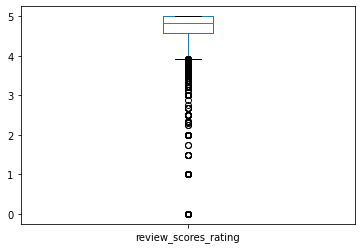

In [16]:
x1 = Airbnb_NTA['review_scores_rating'].plot(kind='box')

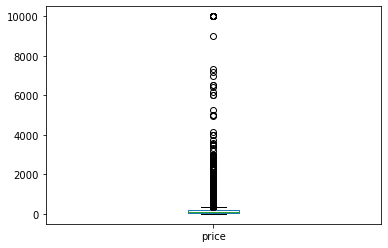

In [17]:
x2 = Airbnb_NTA['price'].plot(kind='box')

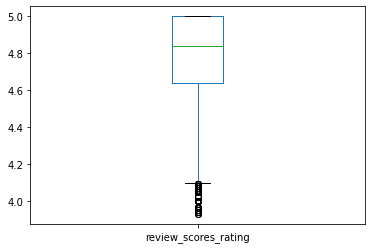

In [18]:
x3 = df['review_scores_rating'].plot(kind='box')

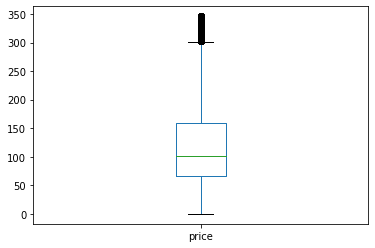

In [19]:
x4 = df['price'].plot(kind='box')